In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import cv2

In [7]:
exp_dir = "../experiments/rocket/nov_28/t1"

In [8]:
desc = yaml.load(open(exp_dir + "/desc.yaml"), yaml.Loader)

In [67]:
def opencv_matrix(loader, node):
    mapping = loader.construct_mapping(node, deep=True)
    mat = np.array(mapping["data"])
    mat.resize(mapping["rows"], mapping["cols"])
    return mat

def load_camera_k_d(path):
    t = open(path, "r").read()
    t = t.replace("%YAML:1.0", "")
    yaml.add_constructor(u"tag:yaml.org,2002:opencv-matrix", opencv_matrix)
    return (lambda x: (x["K"], x["D"][0], (x["cam_width"], x["cam_height"])))(yaml.load(t, Loader=yaml.FullLoader))



In [68]:
calib_0 = load_camera_k_d("calibs/" + desc["camera_0"] + ".yaml")
calib_1 = load_camera_k_d("calibs/" + desc["camera_1"] + ".yaml")

In [69]:
markers = list(desc["markers"].keys())
markers

['light_1_a', 'light_1_b', 'light_2_a', 'light_2_b']

In [70]:
markers_obj_pnts = np.array([desc["markers"][m]["pnt"] for m in markers])
markers_obj_pnts

array([[ 0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  4.43],
       [12.  ,  0.  ,  0.  ],
       [12.  ,  0.  ,  4.43]])

In [71]:
def get_track_path(v):
    return ".".join(v.split(".")[:-1]) + ".txt"

In [91]:
def load_track_txt(track_txt_path, calib) -> pd.DataFrame:
    # track_txt_path = "../experiments/rocket/nov_28/t1/VID_20241129_011318_2.txt"
    f = open(track_txt_path, "r")
    f.readline()
    l1 = f.readline()[:-2]
    l2 = f.readline()[:-2] # x = -y
    track_names = [i for i in l1.split("\t") if i != ""]
    columns = l2.split("\t")

    cn_per_track = int( (len(columns) - 1) / len(track_names) )

    for i in range(1, len(columns)):
        columns[i] = track_names[(i-1)//cn_per_track] + "__" + columns[i]


    data = np.array([[float('nan') if j == "" else float(j.strip())  for j in i[:-1].split("\t")]for i in f.readlines()])

    df = pd.DataFrame(data, columns=columns)
    df.copy()
    for tn in track_names:
        df[tn + "__pixelx"], df[tn + "__pixely"] = df[tn + "__pixely"], calib[2][1] -df[tn + "__pixelx"]
    # df["px"] = df[""]
    return df

In [92]:
def interpolate_markers(df) -> pd.DataFrame:
    out = df.copy()
    out[[i for i in df.columns if "light" in i]] = out[[i for i in out.columns if "light" in i]].interpolate(method="linear", limit_direction="both")
    return out

In [93]:
def interpolate_data_frame_to_new_t(df, t_new) -> pd.DataFrame:
    return pd.DataFrame({
        c: np.interp(t_new, df["t"], df[c])
        for c in df.columns
    })

In [189]:
def get_marker_img_pnts(df: pd.DataFrame) -> np.ndarray:
    xx = np.expand_dims(df[[m + "__pixelx" for m in markers]].to_numpy(), axis=2)
    yy = np.expand_dims(df[[m + "__pixely" for m in markers]].to_numpy(), axis=2)
    return np.concatenate([xx, yy], axis=2)

def get_track_img_pnt(df: pd.DataFrame, track="A") -> np.ndarray:
    return df[[track+"__pixelx", track+"__pixely"]].to_numpy()


In [190]:
def calculate_camera_pose(marker_img, calib):
    ret, rvec, tvec = cv2.solvePnP(markers_obj_pnts.astype(np.float64), marker_img.astype(np.float64), 
                                   calib[0].astype(np.float64), calib[1].astype(np.float64), 
                                           flags=cv2.SOLVEPNP_IPPE
                                           )

    print("ret", ret, "rvec", rvec, "tvec", tvec)
    R, _ = cv2.Rodrigues(rvec)
    # if R[2, 2] > 0:
    #     print("R[2, 2] > 0")
    #     R = R @ np.array([
    #         [0, -1, 0],
    #         [-1, 0, 0],
    #         [0, 0, -1]
    #     ])
    
    T_cm = np.eye(4, 4); T_cm[:3, :3] = R; T_cm[:3, 3] = tvec.reshape(3)
    return np.linalg.inv(T_cm)

In [191]:
d0 = interpolate_markers(load_track_txt(get_track_path(exp_dir + "/" + desc["video_0"]), calib_0))
d1 = interpolate_markers(load_track_txt(get_track_path(exp_dir + "/" + desc["video_1"]), calib_1))
d0["t"] -= desc["manual_t0_0"]
d1["t"] -= desc["manual_t0_1"]

In [192]:
interp_range =[max([-0.1, d0["t"].min(), d1["t"].min()]), max(d0["t"].max(),d1["t"].max())]

In [193]:
# dt = 
t_new = np.arange(interp_range[0], interp_range[1], 0.02)

In [194]:
d0_new_t = interpolate_data_frame_to_new_t(d0, t_new)
d1_new_t = interpolate_data_frame_to_new_t(d1, t_new)

In [246]:
# d0["bench_1__pixely"]

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
530   NaN
531   NaN
532   NaN
533   NaN
534   NaN
Name: bench_1__pixely, Length: 535, dtype: float64

In [195]:
m0 = get_marker_img_pnts(d0_new_t)
m1 = get_marker_img_pnts(d1_new_t)

In [197]:
A0 = get_track_img_pnt(d0_new_t)
A1 = get_track_img_pnt(d1_new_t)

In [253]:
d0["bench_1__pixely"].dropna().iloc[0]

442.4

In [254]:
b1_0 = np.array([d0["bench_1__pixelx"].dropna().iloc[0], d0["bench_1__pixely"].dropna().iloc[0]])
b1_1 = np.array([d1["bench_1__pixelx"].dropna().iloc[0], d1["bench_1__pixely"].dropna().iloc[0]])
b2_0 = np.array([d0["bench_2__pixelx"].dropna().iloc[0], d0["bench_2__pixely"].dropna().iloc[0]])
b2_1 = np.array([d1["bench_2__pixelx"].dropna().iloc[0], d1["bench_2__pixely"].dropna().iloc[0]])

In [256]:
# 1d0["bench_1__pixelx"].dropna()

In [257]:
T_c0 = calculate_camera_pose(m0[10], calib_0)

ret True rvec [[ 0.32513731]
 [-1.14589649]
 [-0.49312791]] tvec [[10.99442975]
 [ 3.54563406]
 [24.90209641]]


In [258]:
T_c0[:3, 3]

array([-21.21154197, -17.41509327,   0.59027593])

In [259]:
T_c1 = calculate_camera_pose(m1[10], calib_1)

ret True rvec [[-0.54122217]
 [-1.25706263]
 [ 0.68115409]] tvec [[ 8.55646974]
 [-1.0345444 ]
 [23.99738448]]


In [260]:
np.linalg.norm(T_c0[:3, 3][:2])

27.444762458458676

In [261]:
np.linalg.norm(T_c1[:3, 3][:2])

25.34913887945893

In [262]:
def find_point_near_2rays(ray1_origin, ray1_vector, ray2_origin, ray2_vector) -> np.ndarray:
    # some geometry here
    R = ray1_origin.reshape(3, 1)
    S = ray2_origin.reshape(3, 1)
    r = ray1_vector.reshape(3, 1)
    s = ray2_vector.reshape(3, 1)
    c1 = (r.T @ r)[0][0]
    c2 = -(r.T @ s)[0][0]
    d1 = -c2
    d2 = -(s.T @ s)[0][0]
    c3 = -((R-S).T @ r)[0][0]
    d3 = -((R-S).T @ s)[0][0]
    albe = np.linalg.inv(np.array([[c1, c2], [d1, d2]])) @ np.array([[c3], [d3]])
    # print(albe)
    al, be = albe.T.flatten()
    point = np.array(((al * r + R) + (be * s + S)) / 2).reshape(3)

    # r = np.matrix(ray1_vector).T; q = np.matrix(ray1_origin).T; s = np.matrix(ray2_vector).T; p = np.matrix(ray2_origin).T
    # rrss = np.hstack([np.vstack([(r.T @ r), (r.T @ s)]), np.vstack([-(s.T @ r), -(s.T @ s)])])
    # u = np.array(np.linalg.pinv(rrss) @ np.matrix((np.array([[(p - q).T], [(p - q).T]]) @ np.array([[r], [s]]))).T).T[0]
    # point = np.array(((u[0] * r + q) + (u[1] * s + p)) / 2).reshape(3)

    return point

In [263]:
def find_ray(T_c, calib, uv):
    vec = np.array([*cv2.undistortPoints(
        np.array(np.array(uv).reshape(2, 1),dtype="float64"),
        calib[0],
        calib[1],
    ).reshape(2), 1])

    return T_c[:3, 3], T_c[:3, :3] @ vec

In [264]:
def find_point(p0, p1):
    o0, v0 = find_ray(T_c0, calib_0, p0)
    o1, v1 = find_ray(T_c1, calib_1, p1)
    return find_point_near_2rays(o0, v0, o1, v1)

In [267]:
bench_1_p = find_point(b1_0, b1_1)
bench_2_p = find_point(b2_0, b2_1)

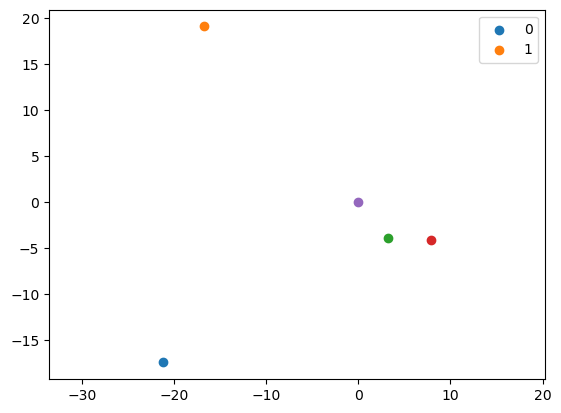

In [272]:
plt.scatter([T_c0[:3, 3][0]], [T_c0[:3, 3][1]], label="0")
plt.scatter([T_c1[:3, 3][0]], [T_c1[:3, 3][1]], label="1")
plt.scatter([bench_1_p[0]], [bench_1_p[1]])
plt.scatter([bench_2_p[0]], [bench_2_p[1]])
plt.scatter([0], [0])
plt.gca().axis('equal')
plt.legend()

In [269]:
np.linalg.norm(bench_1_p - bench_2_p)

4.676108474272222

In [233]:
pnts = []
NN = 330
for N in range(NN):
    pnts.append(find_point(A0[N], A1[N]))
pnts = np.array(pnts)

In [234]:
o0, v0 = find_ray(T_c0, calib_0, b1_0[N])
o1, v1 = find_ray(T_c1, calib_1, A1[N])
pnts.append(find_point_near_2rays(o0, v0, o1, v1))

AttributeError: 'numpy.ndarray' object has no attribute 'append'

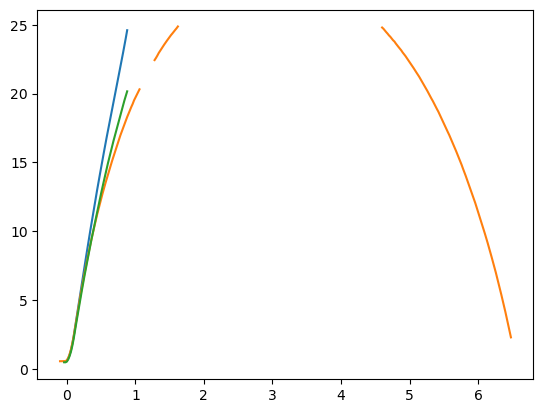

In [235]:
plt.plot(t_new[:NN], pnts[:, 2])
plt.plot(t_new[:NN], d0_new_t["A__x"][:NN])
plt.plot(t_new[:NN], d1_new_t["A__x"][:NN])

In [277]:
import pyvista as pv
pv.set_jupyter_backend('html')
# pv.set_jupyter_backend('trame')
pv.global_theme.axes.x_color = 'red'
pv.global_theme.axes.y_color = 'green'
pv.global_theme.axes.z_color = 'blue'
# pv.set_jupyter_backend('client')
# pv.global_theme.jupyter_backend = "panel"


p = pv.Plotter()

p.add_text("Mesh", font_size=24)
axes = pv.Axes(show_actor=True,actor_scale=2, line_width=5)
axes.axes_actor.x_axis_shaft_properties.color = (1, 0, 0)
axes.axes_actor.y_axis_shaft_properties.color = (0, 1, 0)
axes.axes_actor.z_axis_shaft_properties.color = (0, 0, 1)
axes.origin = (0, 0, 0)
axes.actor.user_matrix = T_c0
p.add_actor(axes.actor)
axes = pv.Axes(show_actor=True,actor_scale=2, line_width=5)
axes.axes_actor.x_axis_shaft_properties.color = (1, 0, 0)
axes.axes_actor.y_axis_shaft_properties.color = (0, 1, 0)
axes.axes_actor.z_axis_shaft_properties.color = (0, 0, 1)
axes.origin = (0, 0, 0)
axes.actor.user_matrix = T_c1
p.add_actor(axes.actor)
p.add_actor(pv.Axes(show_actor=True,actor_scale=5, line_width=2).actor)

# for N in range(40):
    
#     o, v = find_ray(T_c0, calib_0, A0[N])
#     actor = p.add_lines(o + np.array([v*i for i in np.linspace(0, 30, 2)]), color='purple', width=3)

#     o, v = find_ray(T_c1, calib_1, A1[N])
actor = p.add_points(pnts, color='green')
actor = p.add_points(np.array([bench_1_p, bench_2_p]), color='red')
# # p.camera = camera
# p.add_mesh(mesh)

p.show()


EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

In [147]:
m0[0]

array([[1715. ,  778.3],
       [1410. ,  765.9],
       [1705. ,  402. ],
       [1475. ,  408.1]])

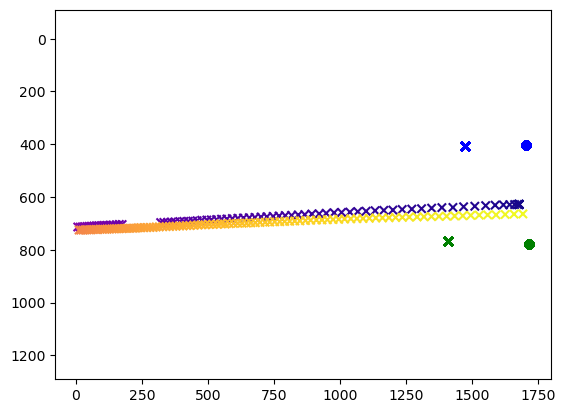

In [121]:
# plt.figure(figsize=(1, 5))
def _():
    d0 = d0_new_t
    plt.gca().axis('equal')
    plt.scatter(d0["A__pixelx"], d0["A__pixely"], marker="x", c=d0["t"], cmap="plasma")
    plt.scatter(d0["light_1_a__pixelx"], d0["light_1_a__pixely"], marker="o", c="g")
    plt.scatter(d0["light_1_b__pixelx"], d0["light_1_b__pixely"], marker="x", c="g")
    plt.scatter(d0["light_2_a__pixelx"], d0["light_2_a__pixely"], marker="o", c="b")
    plt.scatter(d0["light_2_b__pixelx"], d0["light_2_b__pixely"], marker="x", c="b")
    plt.gca().invert_yaxis()
_()

In [463]:
# d0_new_t

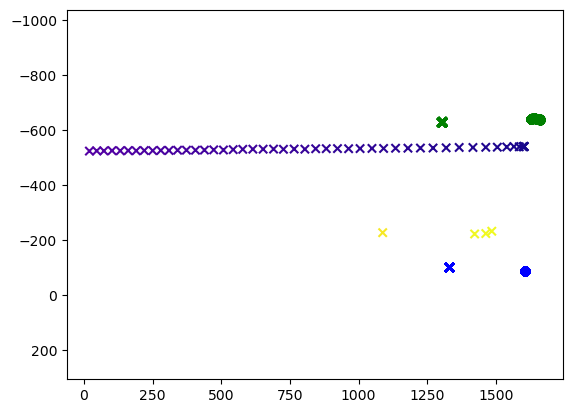

In [464]:
def _():
    d0 = d1_new_t
    plt.gca().axis('equal')
    plt.scatter(d0["A__pixelx"], d0["A__pixely"], marker="x", c=d0["t"], cmap="plasma")
    plt.scatter(d0["light_1_a__pixelx"], d0["light_1_a__pixely"], marker="o", c="g")
    plt.scatter(d0["light_1_b__pixelx"], d0["light_1_b__pixely"], marker="x", c="g")
    plt.scatter(d0["light_2_a__pixelx"], d0["light_2_a__pixely"], marker="o", c="b")
    plt.scatter(d0["light_2_b__pixelx"], d0["light_2_b__pixely"], marker="x", c="b")
    plt.gca().invert_yaxis()
_()